# USD MSADS 505 Final Project - Team 3
# Caleb McCurdy, Jesse Gutierrez, and Jessica Hin

Importing required libraries and packages

In [65]:
# Import necessary packages
import pandas as pd 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.tools.tools as stattools
import matplotlib
import matplotlib.pyplot as plt
import dmba
import kds
import statsmodels.api as sma
import klib
import os
import xgboost as xgb
#import tensorflow as tf

from sklearn import preprocessing, tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error as MSE, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample
from sklearn.svm import SVC

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba.metric import AIC_score

from imblearn.over_sampling import RandomOverSampler

from klib import corr_plot

from scipy.stats import yeojohnson

#from tensorflow import keras

%matplotlib inline

This code chunk is to prevent lenghty warning messages from appearing during notebook rendering.

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


# Part 1 - EDA
## Describing the data and data information

In [3]:
# Load the bank-full spreadsheet
df = pd.read_csv('bank-full.csv', sep=";")
# Display the first 5 rows to preview table
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Display the dimension of the spreadsheet
df.shape

(45211, 17)

In [5]:
# Display column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
# Display the data types
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [7]:
# Display null values
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
# Display unique outputs
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

Identifying which variables are numeric and which ones are catgorical.

In [10]:
# create subsets of the variables by type
num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# updating objects to categorical type
df[cat_vars] = df[cat_vars].astype('category') 

In [11]:
# Subset the data to only have the numeric data
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Display the header
numeric_df.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


## Visualizations the numeric variables  
### Boxplots

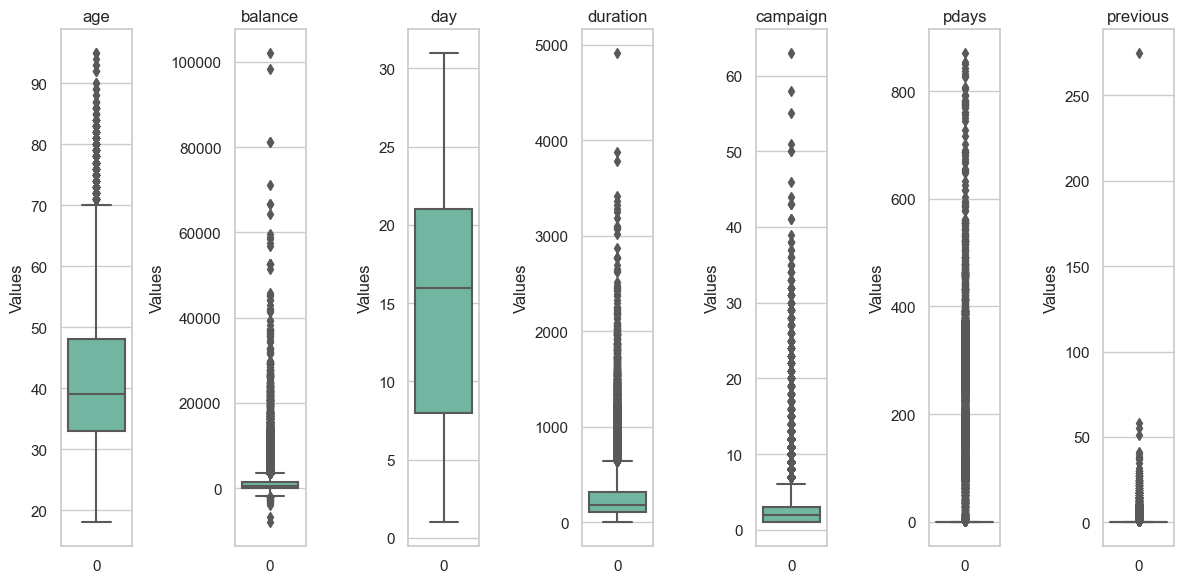

In [12]:
# Establish the style for the plots
sns.set(style="whitegrid")

# Create separate boxplots for each numeric column
plt.figure(figsize=(12, 6))

# Create a loop to generate independent subplots
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(1, len(numeric_df.columns), i)
    sns.boxplot(data=numeric_df[col], orient="v", palette="Set2")
    plt.title(f'{col}')
    plt.ylabel('Values')
# Combine & display outputs
plt.tight_layout()
plt.show()

### Scatterplots

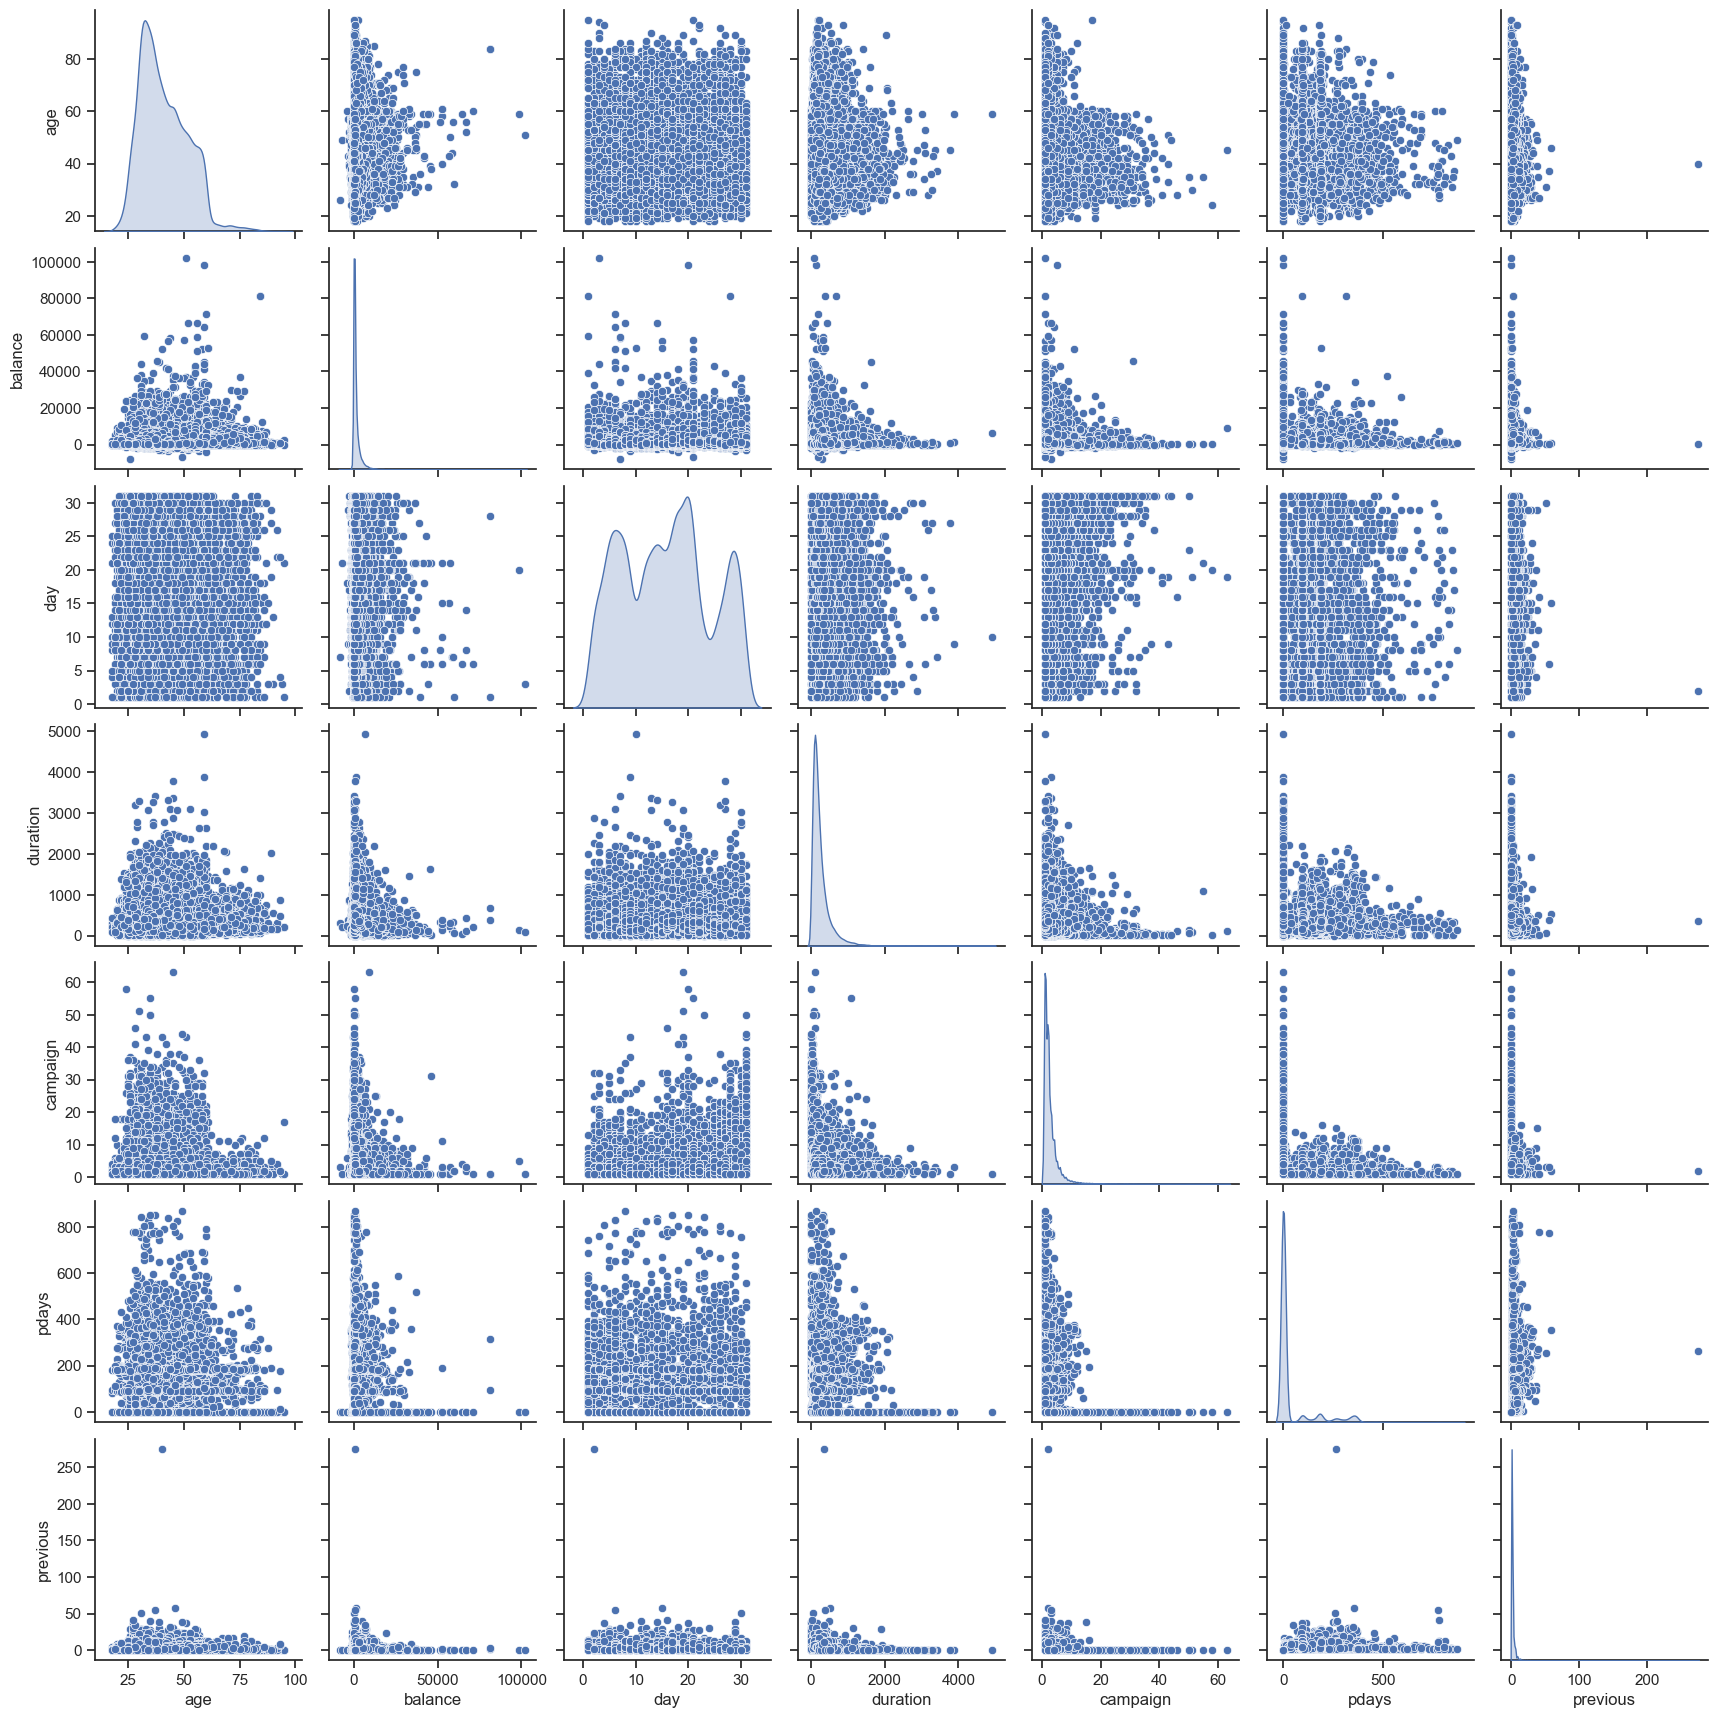

In [13]:
# Plot observations among all numeric attributes to compare distribution

# Establish the style for the plots
sns.set(style="ticks")

# Create pairplot
sns.pairplot(numeric_df, diag_kind='kde', markers='o')

# Display the plots
plt.show()

### Histograms

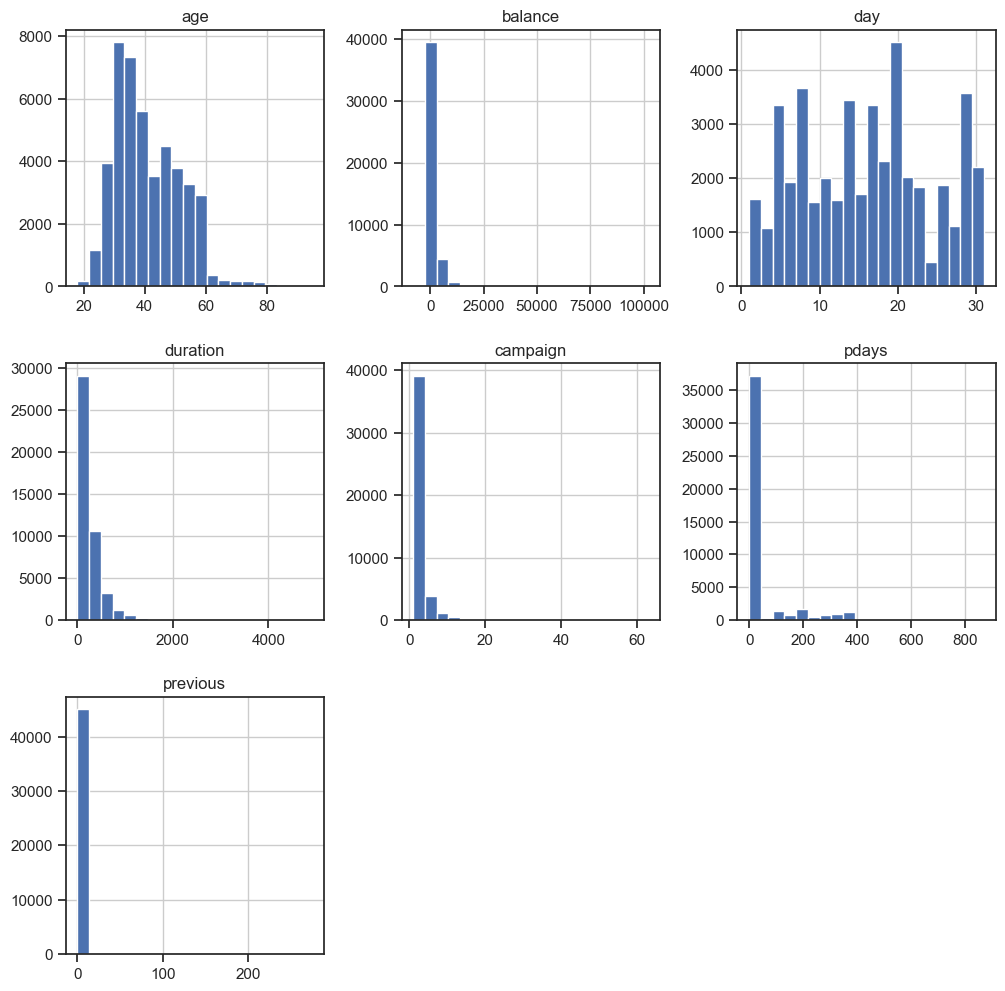

In [14]:
df[num_vars].hist(figsize=(12,12),bins=20)
plt.show()

### Correlation Plot

<Axes: title={'center': 'Feature-correlation (pearson)'}>

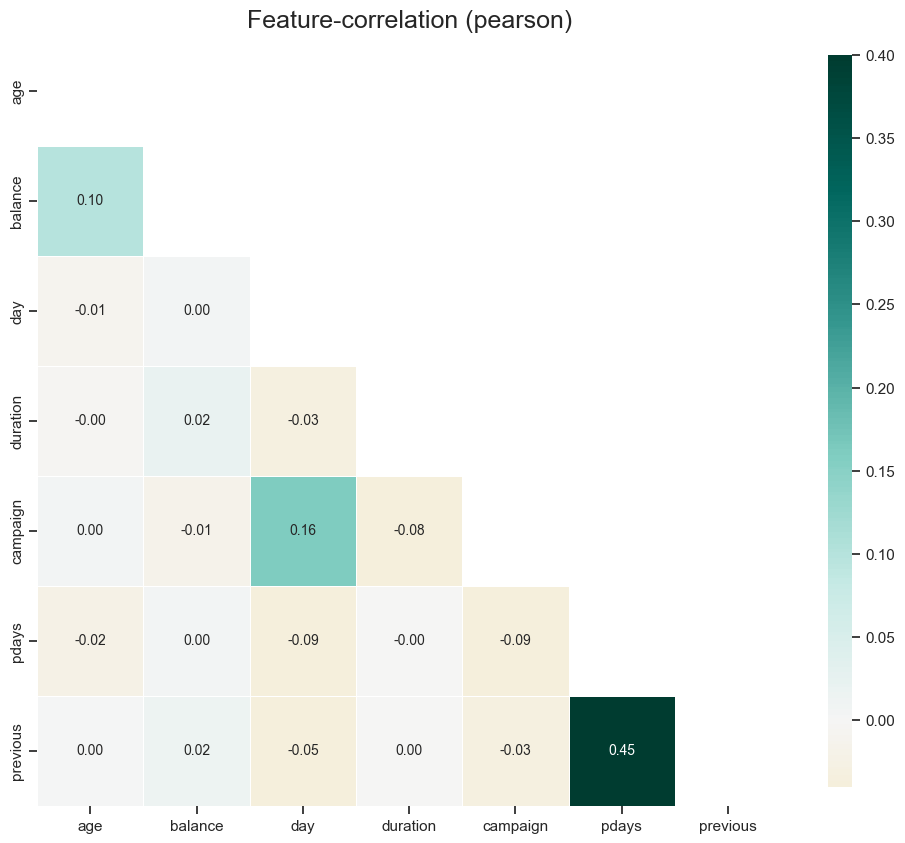

In [15]:
klib.corr_plot(df[num_vars])

## Visualizations of the categorical variables  
### Histograms with respect to the response variable 'y'

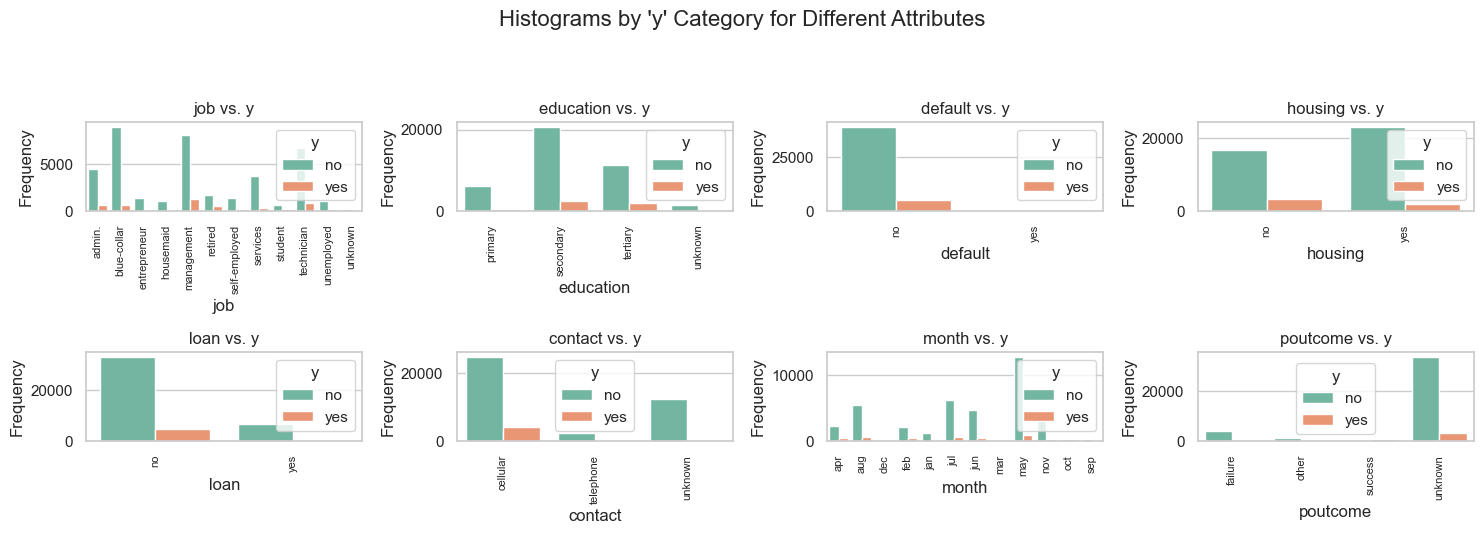

In [16]:
# Set the style for the plots (optional)
sns.set(style="whitegrid")

# List of columns to include in the grid
columns_to_compare = ['job', 'education', 'default', 'housing', 'loan', 'contact',
                      'month', 'poutcome']

# Create a grid of histograms comparing each column to 'y'
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.suptitle("Histograms by 'y' Category for Different Attributes", fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through the specified columns and create histograms for each
for i, col in enumerate(columns_to_compare):
    ax = axes[i]
    
    # Rotate x-axis labels by 45 degrees and set a smaller font size
    sns.countplot(data=df, x=col, hue='y', ax=ax, palette="Set2")
    ax.set_title(f'{col} vs. y')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
# Remove any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

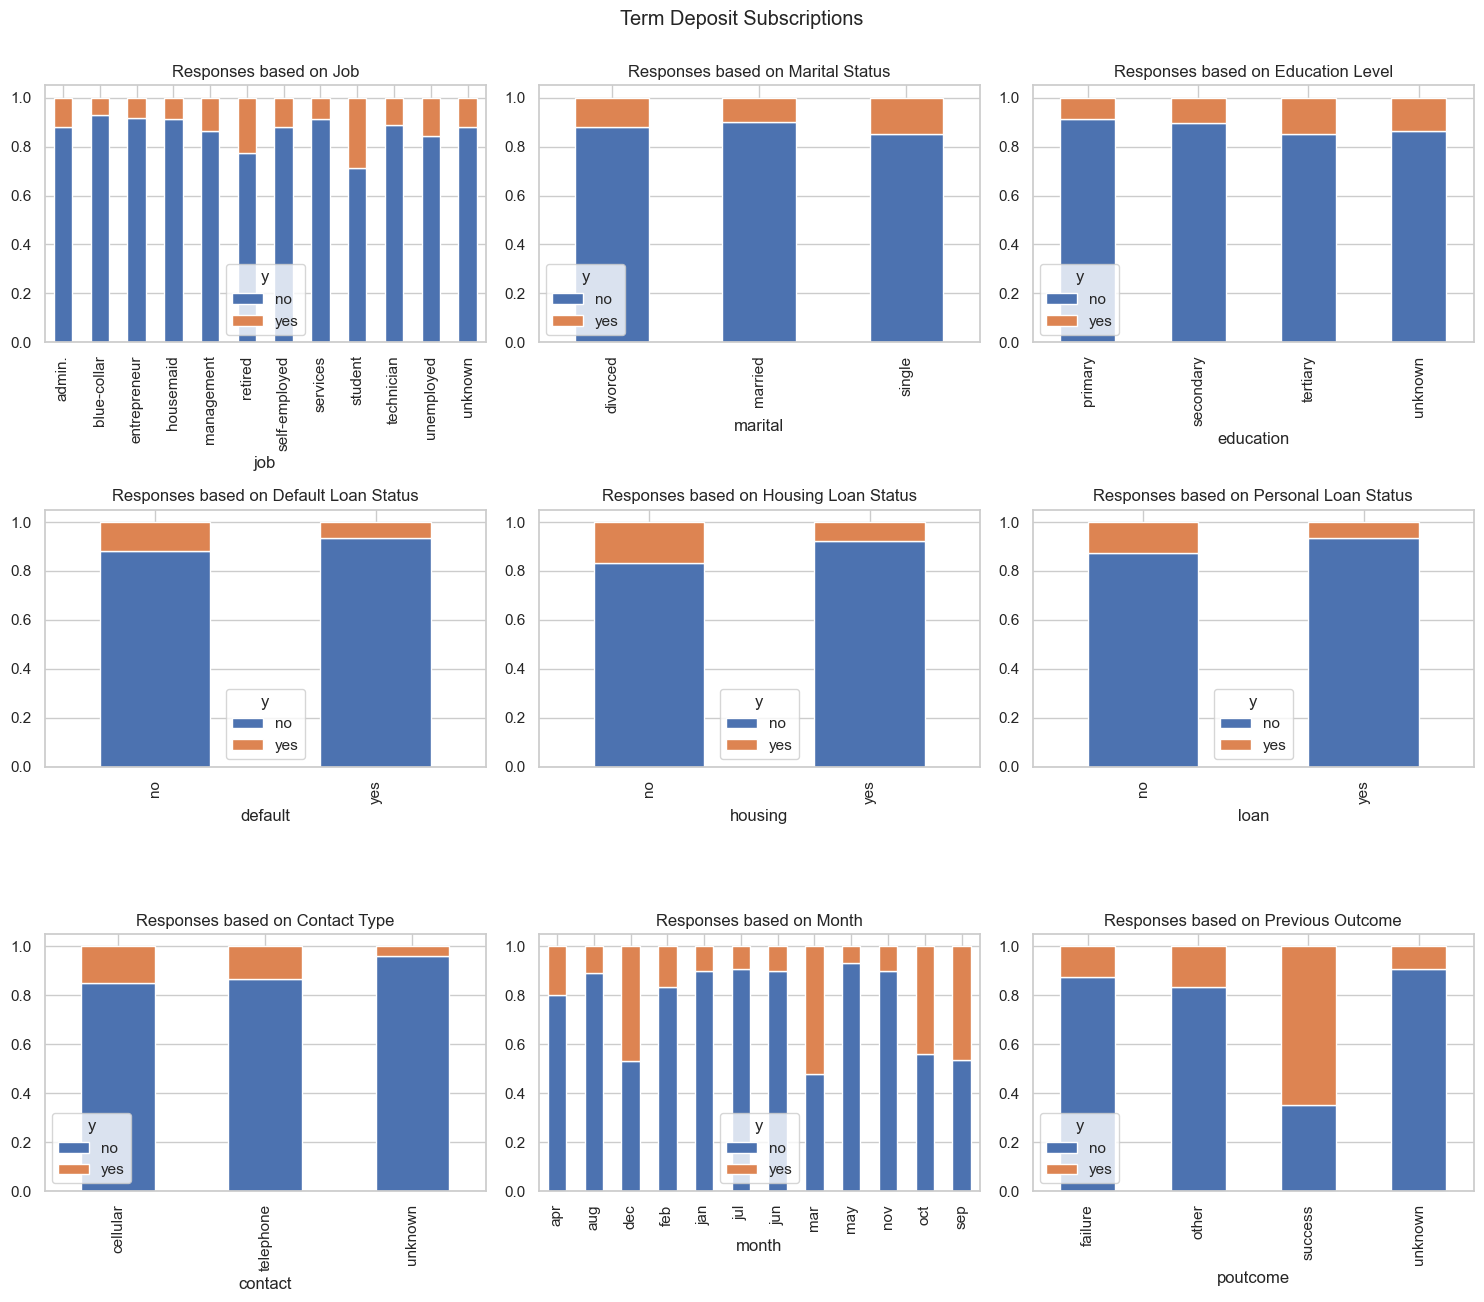

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13))
fig.suptitle('Term Deposit Subscriptions', y=1)

# plotting by job
ax0 = pd.crosstab(df['job'], df['y'])
ax0 = ax0.div(ax0.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][0])
ax0.set_title('Responses based on Job')

# plotting by marital
ax1 = pd.crosstab(df['marital'], df['y'])
ax1 = ax1.div(ax1.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][1])
ax1.set_title('Responses based on Marital Status')

# plotting by education
ax2 = pd.crosstab(df['education'], df['y'])
ax2 = ax2.div(ax2.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][2])
ax2.set_title('Responses based on Education Level')

# plotting by default
ax3 = pd.crosstab(df['default'], df['y'])
ax3 = ax3.div(ax3.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][0])
ax3.set_title('Responses based on Default Loan Status')

# plotting by housing
ax4 = pd.crosstab(df['housing'], df['y'])
ax4 = ax4.div(ax4.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][1])
ax4.set_title('Responses based on Housing Loan Status')

# plotting by loan
ax5 = pd.crosstab(df['loan'], df['y'])
ax5 = ax5.div(ax5.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][2])
ax5.set_title('Responses based on Personal Loan Status')

# plotting by contact
ax6 = pd.crosstab(df['contact'], df['y'])
ax6 = ax6.div(ax6.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][0])
ax6.set_title('Responses based on Contact Type')

# plotting by month
ax7 = pd.crosstab(df['month'], df['y'])
ax7 = ax7.div(ax7.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][1])
ax7.set_title('Responses based on Month')

# plotting by poutcome
ax8 = pd.crosstab(df['poutcome'], df['y'])
ax8 = ax8.div(ax8.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][2])
ax8.set_title('Responses based on Previous Outcome')

plt.tight_layout()
plt.show()

### Boxplots of categorical variables with respect to y

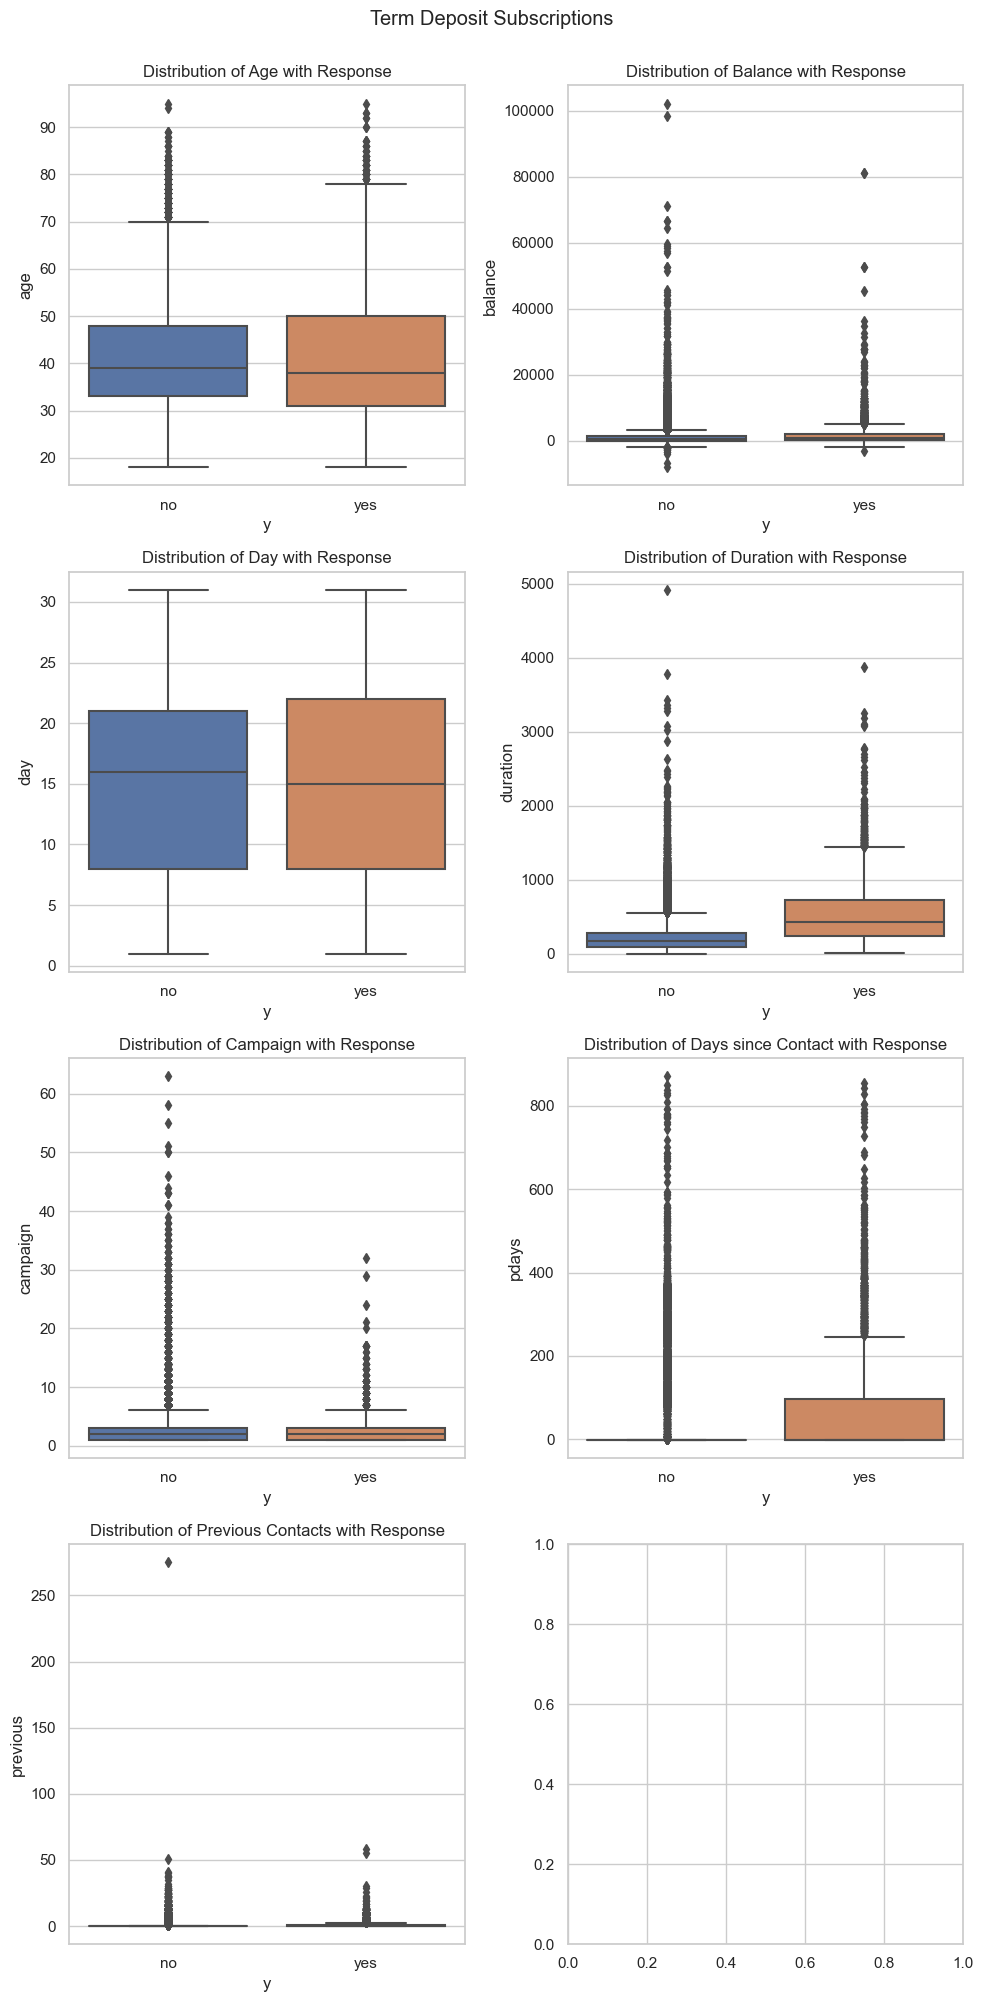

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
fig.suptitle('Term Deposit Subscriptions', y=1)

# plotting by age
ax0 = sns.boxplot(y="age", x='y', data=df, ax = axes[0][0])
ax0.set_title('Distribution of Age with Response')

# plotting by balance
ax1 = sns.boxplot(y="balance", x='y', data=df, ax = axes[0][1])
ax1.set_title('Distribution of Balance with Response')

# plotting by day
ax2 = sns.boxplot(y="day", x='y', data=df, ax = axes[1][0])
ax2.set_title('Distribution of Day with Response')

# plotting by duration
ax3 = sns.boxplot(y="duration", x='y', data=df, ax = axes[1][1])
ax3.set_title('Distribution of Duration with Response')

# plotting by campaign
ax4 = sns.boxplot(y="campaign", x='y', data=df, ax = axes[2][0])
ax4.set_title('Distribution of Campaign with Response')

# plotting by pdays
ax5 = sns.boxplot(y="pdays", x='y', data=df, ax = axes[2][1])
ax5.set_title('Distribution of Days since Contact with Response')

# plotting by previous
ax6 = sns.boxplot(y="previous", x='y', data=df, ax = axes[3][0])
ax6.set_title('Distribution of Previous Contacts with Response')

plt.tight_layout()
plt.show()

## Visualizations for the records that had 'y' = Yes

In [19]:
# Categorical columns to analyze
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'campaign', 'previous', 'poutcome']

# Varaible used to store the results
results = []

# Iterate through the categorical columns
for col in categorical_columns:
    unique_values = df[col].unique()
    for value in unique_values:
        sub_df = df[df[col] == value]
        total_count = sub_df.shape[0]  
        yes_count = sub_df[sub_df['y'] == 'yes'].shape[0]
        percentage = (yes_count / total_count) * 100 if total_count > 0 else 0.0
        results.append({'Column': col, 'Value': value, 'Percentage': percentage, 'Total Frequency': total_count})

# Save the results as a Data Frame
result_df = pd.DataFrame(results)

# Sort results in descending order
result_df = result_df.sort_values(by='Percentage', ascending=False)

# Display top 20 unique values
result_df.head(20)

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
132,poutcome,success,64.725347,1511
37,month,mar,51.991614,477
106,previous,26,50.000000,2
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
97,previous,10,38.805970,67
121,previous,30,33.333333,3


In [20]:
# Wanted to further look at the distribution among each attribute
month_df = result_df[result_df['Column'] == 'month']
# Display table
month_df

,Column,Value,Percentage,Total Frequency
37,month,mar,51.991614,477
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
38,month,apr,19.679400,2932
36,month,feb,16.647792,2649
31,month,aug,11.013286,6247
29,month,jun,10.222805,5341
33,month,nov,10.151134,3970
35,month,jan,10.121169,1403


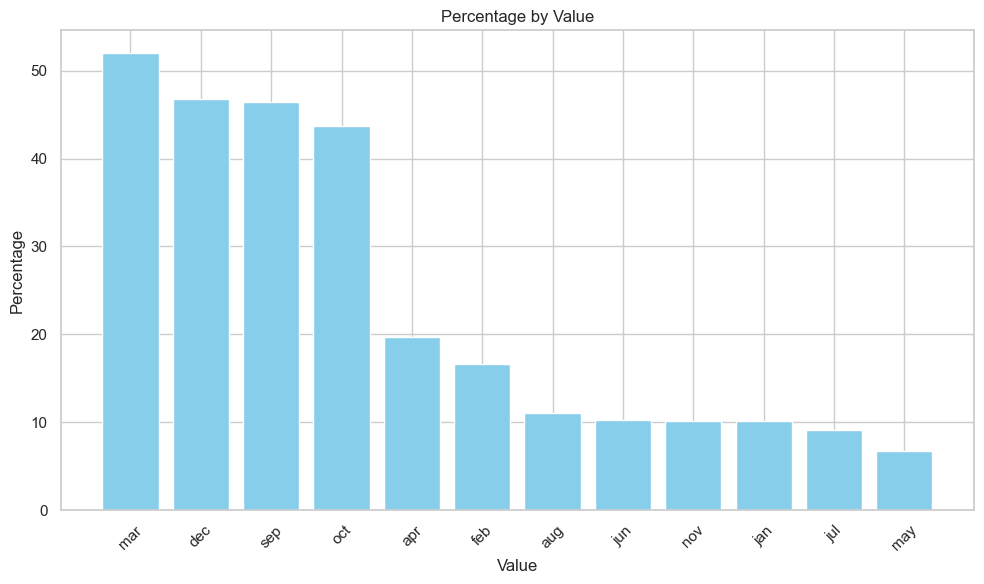

In [21]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(month_df['Value'], month_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [22]:
# Wanted to further look at the distribution among each attribute
marital_df = result_df[result_df['Column'] == 'marital']
# Display table
marital_df

,Column,Value,Percentage,Total Frequency
13,marital,single,14.949179,12790
14,marital,divorced,11.945458,5207
12,marital,married,10.123466,27214


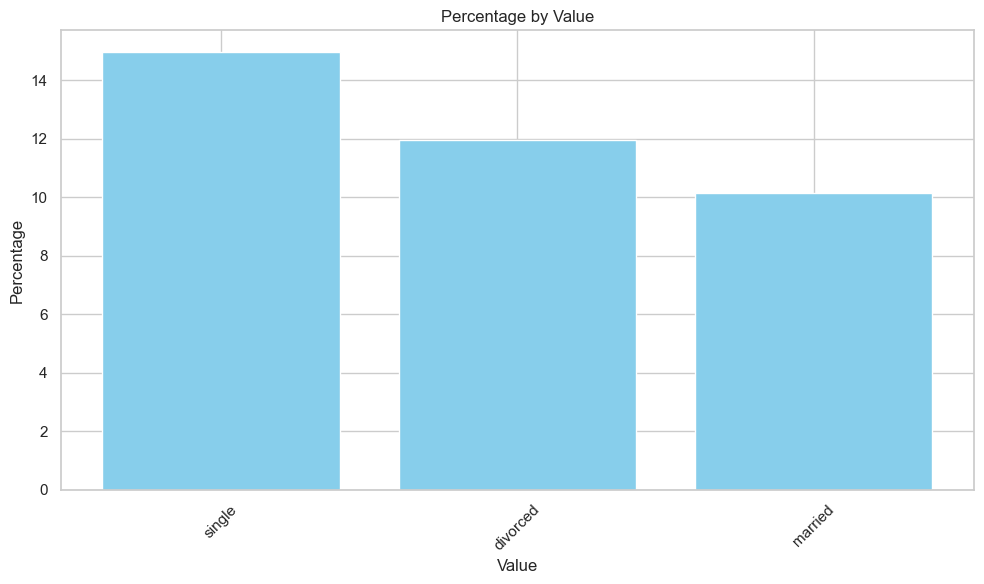

In [23]:
# Create bar plot for marital status
plt.figure(figsize=(10, 6))
plt.bar(marital_df['Value'], marital_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [24]:
# Wanted to further look at the distribution among each attribute
job_df = result_df[result_df['Column'] == 'job']
# Display table
job_df

,Column,Value,Percentage,Total Frequency
11,job,student,28.678038,938
5,job,retired,22.791519,2264
9,job,unemployed,15.502686,1303
0,job,management,13.755551,9458
6,job,admin.,12.202669,5171
8,job,self-employed,11.842939,1579
4,job,unknown,11.805556,288
1,job,technician,11.056996,7597
7,job,services,8.883004,4154
10,job,housemaid,8.790323,1240


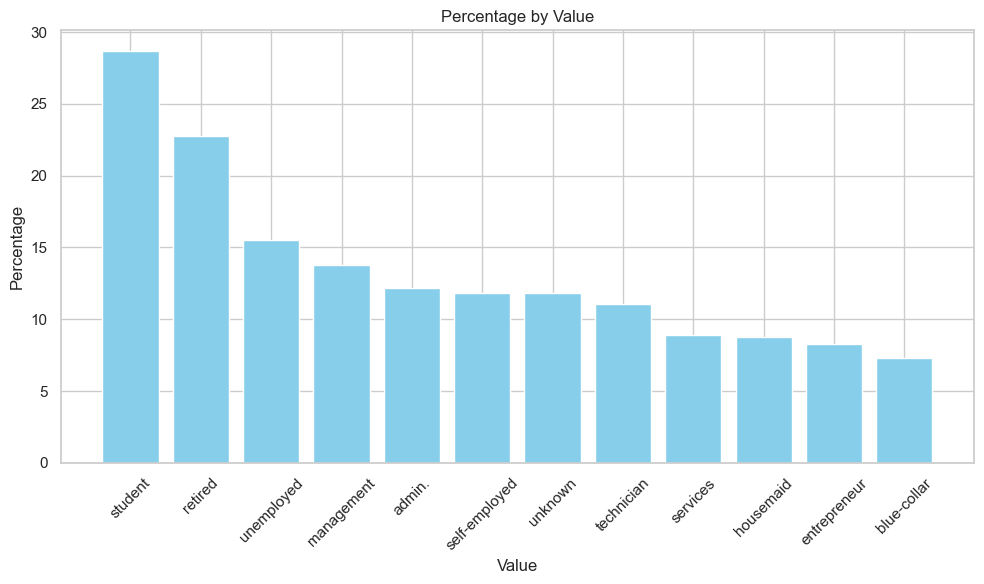

In [25]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(job_df['Value'], job_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [26]:
# Wanted to further look at the distribution among each attribute
education_df = result_df[result_df['Column'] == 'education']
# Display table
education_df

,Column,Value,Percentage,Total Frequency
15,education,tertiary,15.006390,13301
17,education,unknown,13.570275,1857
16,education,secondary,10.559435,23202
18,education,primary,8.626478,6851


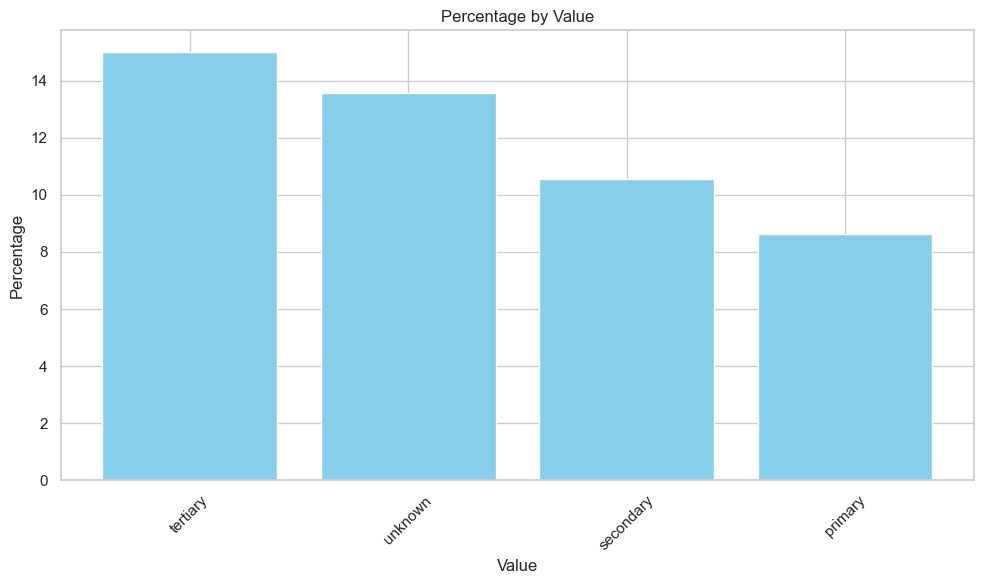

In [27]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(education_df['Value'], education_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [28]:
# Wanted to further look at the distribution among each attribute
default_df = result_df[result_df['Column'] == 'default']
# Display table
default_df

,Column,Value,Percentage,Total Frequency
19,default,no,11.796108,44396
20,default,yes,6.380368,815


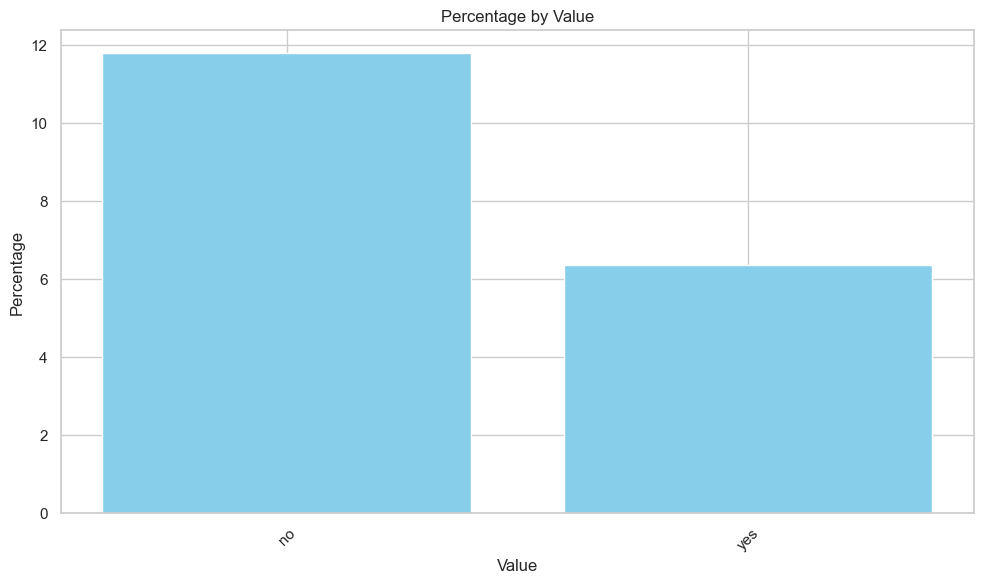

In [29]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(default_df['Value'], default_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [30]:
# Wanted to further look at the distribution among each attribute
housing_df = result_df[result_df['Column'] == 'housing']
# Display table
housing_df

,Column,Value,Percentage,Total Frequency
22,housing,no,16.702355,20081
21,housing,yes,7.699960,25130


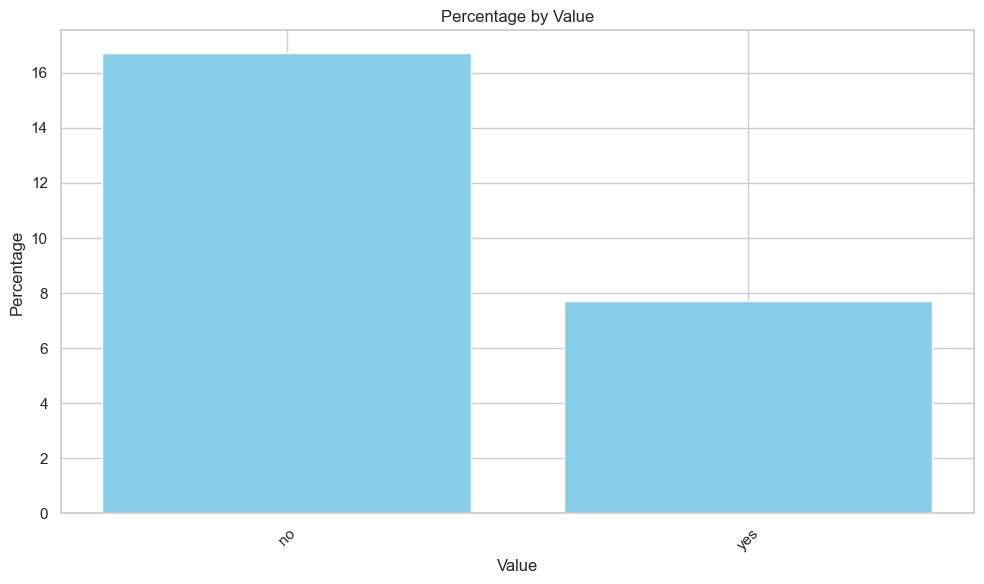

In [31]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(housing_df['Value'], housing_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [32]:
# Wanted to further look at the distribution among each attribute
loan_df = result_df[result_df['Column'] == 'loan']
# Display table
loan_df

,Column,Value,Percentage,Total Frequency
23,loan,no,12.655727,37967
24,loan,yes,6.681391,7244


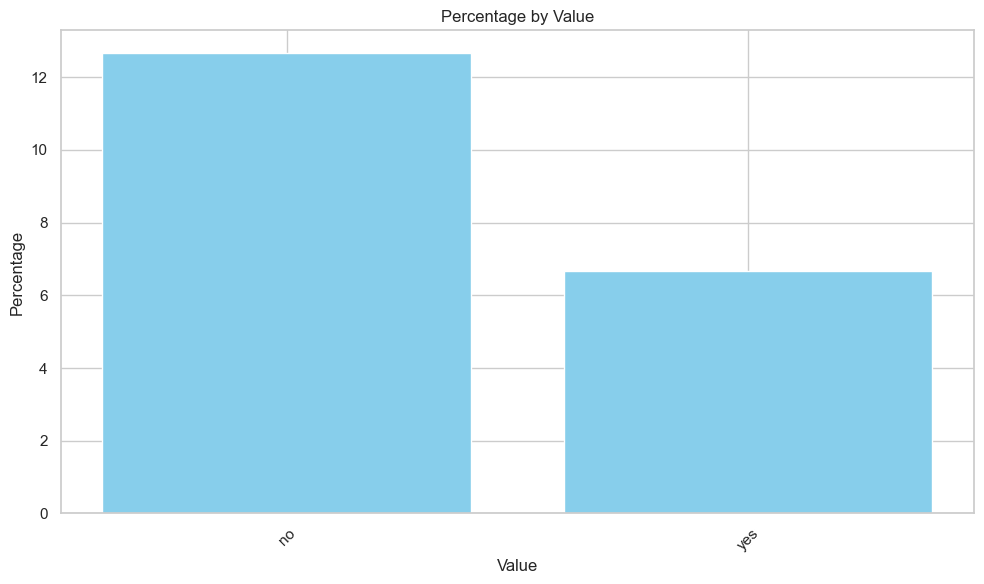

In [33]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(loan_df['Value'], loan_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [34]:
# Wanted to further look at the distribution among each attribute
contact_df = result_df[result_df['Column'] == 'contact']
# Display table
contact_df

,Column,Value,Percentage,Total Frequency
26,contact,cellular,14.918900,29285
27,contact,telephone,13.420509,2906
25,contact,unknown,4.070661,13020


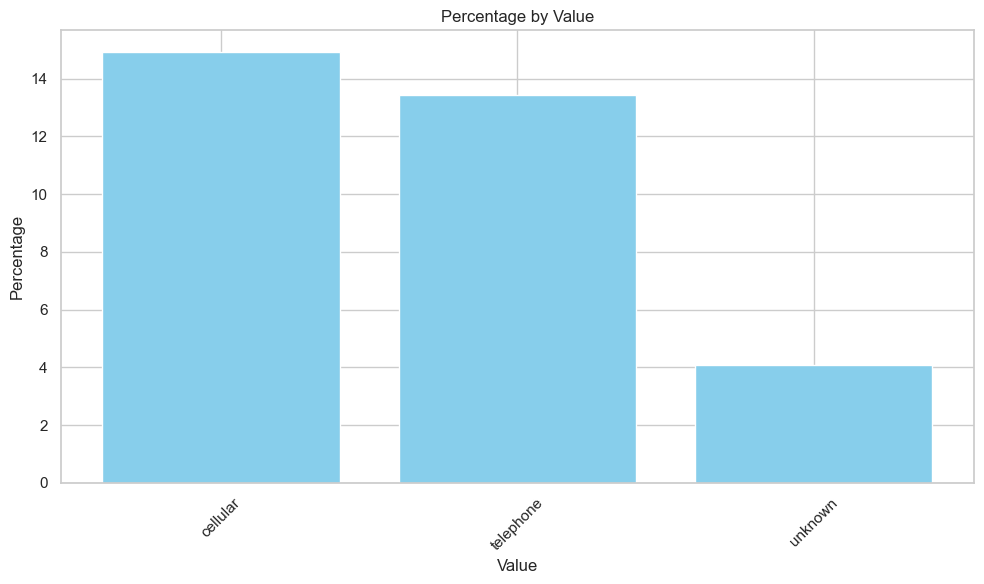

In [35]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(contact_df['Value'], contact_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [36]:
# Wanted to further look at the distribution among each attribute
campaign_df = result_df[result_df['Column'] == 'campaign']
# Display table
campaign_df

,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


In [37]:
# Determine the min. freq. to display w/in table using 5%
campaign_cutoff = round(len(campaign_df) * .05, 0)
# Display the minimum amount of observations that a value needs to be included
print('Minumum observations for campaign results: ', campaign_cutoff)
# Display table
campaign_cutoff_df = campaign_df[campaign_df['Total Frequency'] > campaign_cutoff] 
# Print updated table
campaign_cutoff_df

Minumum observations for campaign results:  2.0


,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


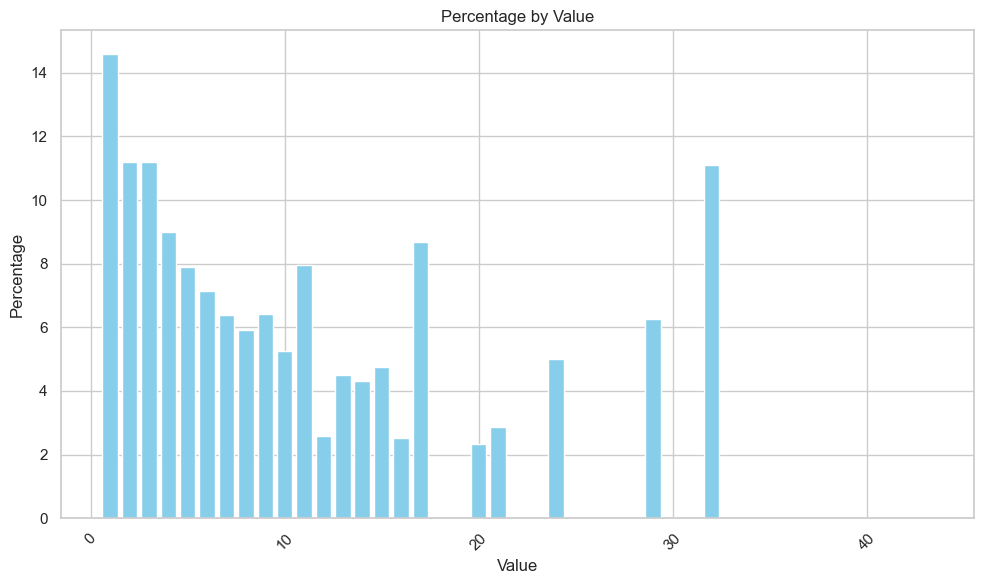

In [38]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(campaign_cutoff_df['Value'], campaign_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [39]:
# Wanted to further look at the distribution among each attribute
previous_df = result_df[result_df['Column'] == 'previous']
# Display table
previous_df

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
106,previous,26,50.000000,2
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19


In [40]:
# Establish min. freq. based on cutoff value of 5%
percentage_cutoff = round(len(previous_df) * .05, 0)
# Display the min. amount of freq.
print('Percent cutoff: ', percentage_cutoff)
# Create a subset accounting for cutoff
previous_cutoff_df = previous_df[previous_df['Total Frequency'] > percentage_cutoff]
# Display results
previous_cutoff_df

Percent cutoff:  2.0


,Column,Value,Percentage,Total Frequency
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19
101,previous,9,26.086957,92
89,previous,3,25.744308,1142
102,previous,21,25.000000,4


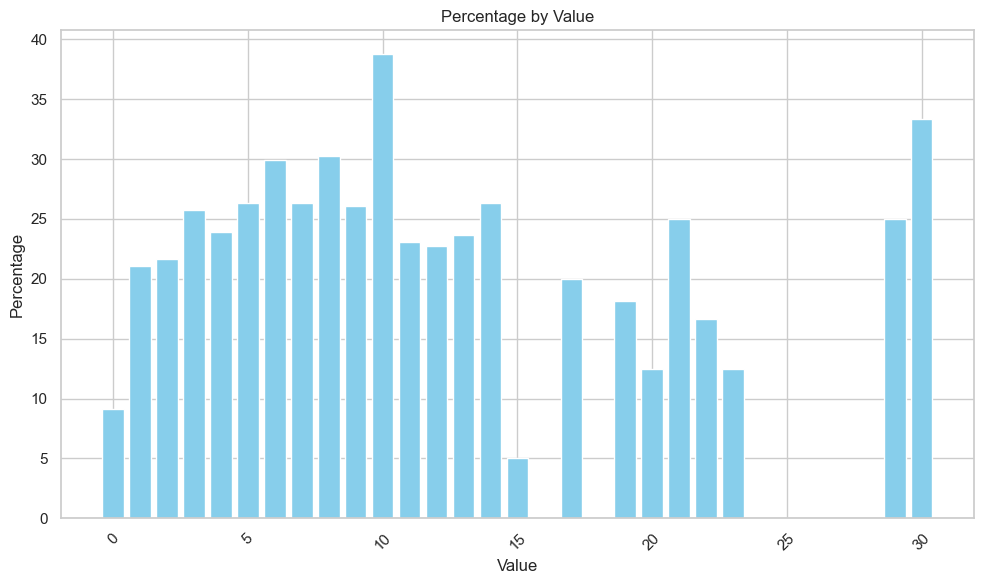

In [41]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(previous_cutoff_df['Value'], previous_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [42]:
# Wanted to further look at the distribution among each attribute
poutcome_df = result_df[result_df['Column'] == 'poutcome']
# Display table
poutcome_df

,Column,Value,Percentage,Total Frequency
132,poutcome,success,64.725347,1511
131,poutcome,other,16.684783,1840
130,poutcome,failure,12.609671,4901
129,poutcome,unknown,9.161503,36959


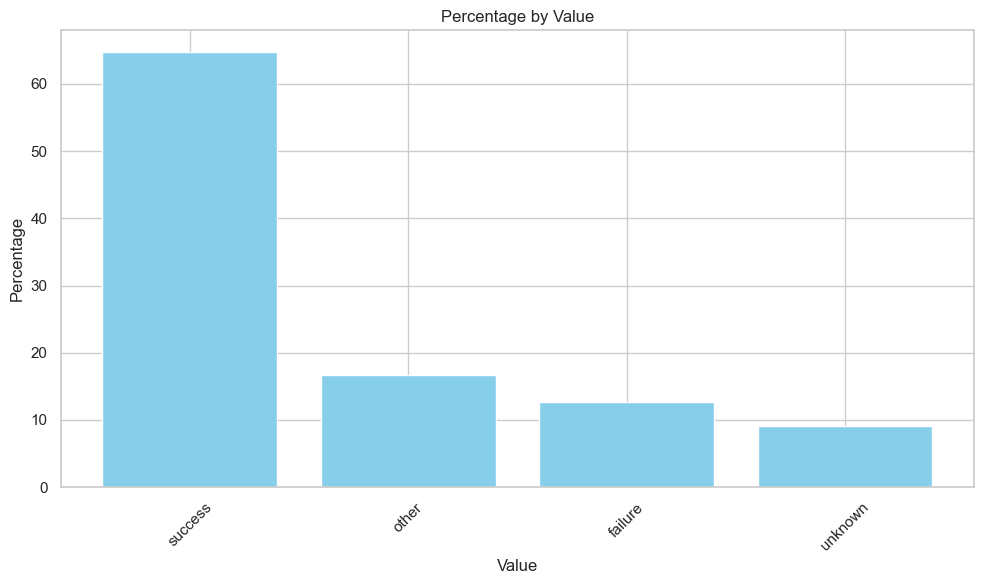

In [43]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(poutcome_df['Value'], poutcome_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

# Part 2 - Data Preprocessing

The portion was added in below, not sure if Jesse wanted to get rid of the knn stuff or the 3 cells above the knn code portion. I'll mark the code cells that I have questions on (Jess) 

In [44]:
# replacing the -1 with 0 in the pdays variable
df['pdays'] = df['pdays'].replace(-1, 0)

## Split the dataset

In [45]:
# train (60%), validation (30%), test (10%) 
X = df.drop(columns=['y'])
y = df[['y']]
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.25, random_state=1)

In [46]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
23520,34,technician,single,tertiary,yes,-6,no,no,cellular,28,aug,79,8,0,0,unknown
14941,58,housemaid,single,tertiary,no,145,yes,yes,cellular,16,jul,128,2,0,0,unknown
40686,38,admin.,married,tertiary,no,4297,no,no,cellular,7,aug,206,2,0,0,unknown
29432,32,self-employed,married,tertiary,no,428,no,yes,cellular,3,feb,142,2,0,0,unknown
840,49,blue-collar,married,secondary,no,64,yes,no,unknown,7,may,293,3,0,0,unknown


In [47]:
# using the yeojohnson transformation because it can take both negative and postive numbers
X_train[num_vars] = X_train[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)
X_test[num_vars] = X_test[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)
X_val[num_vars] = X_val[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)

## Scaling

In [48]:
# Redefine cat_vars to not include the response variable
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Create pipelines for cat and num variables
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
num_pipe = Pipeline([('standardize', StandardScaler())])

# Combine pipelines using ColumnTransformer
all_pipe = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_vars),
        ('num', num_pipe, num_vars)
    ],
    remainder='passthrough'
)

# Fit and transform the training data
X_train_trans = all_pipe.fit_transform(X_train)

# Get feature names for one-hot encoded cat variables
cat_encoder = all_pipe.named_transformers_['cat'].named_steps['encoder']
cat_encoder.fit(X_train[cat_vars])

# get cat feature names
cat_col_names = cat_encoder.get_feature_names_out(cat_vars)

# all feature names
all_col_names = list(cat_col_names) + num_vars

# Reassign the column names to the transformed datasets
X_train_trans = pd.DataFrame(X_train_trans, columns=all_col_names)
X_val_trans = pd.DataFrame(all_pipe.transform(X_val), columns=all_col_names)
X_test_trans = pd.DataFrame(all_pipe.transform(X_test), columns=all_col_names)


In [49]:
X_train_trans

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-0.585290,-0.433445,1.376543,-0.886337,1.702620,-0.472660,-0.472783
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.472928,-0.334094,0.106335,-0.400598,0.125236,-0.472660,-0.472783
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.141070,1.076134,-1.047777,0.112729,0.125236,-0.472660,-0.472783
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.830866,-0.202331,-1.689641,-0.291592,0.125236,-0.472660,-0.472783
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.843488,-0.378788,-1.047777,0.515790,0.729904,-0.472660,-0.472783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.919889,0.315921,-0.129305,0.612370,0.729904,-0.472660,-0.472783
27122,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.585290,-0.160072,0.220930,0.251362,0.125236,-0.472660,-0.472783
27123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.765233,1.045440,0.661153,0.770854,1.485425,-0.472660,-0.472783
27124,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.518475,0.300144,0.553585,-2.528253,1.889098,-0.472660,-0.472783


In [50]:
X_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27126 entries, 0 to 27125
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_admin.           27126 non-null  float64
 1   job_blue-collar      27126 non-null  float64
 2   job_entrepreneur     27126 non-null  float64
 3   job_housemaid        27126 non-null  float64
 4   job_management       27126 non-null  float64
 5   job_retired          27126 non-null  float64
 6   job_self-employed    27126 non-null  float64
 7   job_services         27126 non-null  float64
 8   job_student          27126 non-null  float64
 9   job_technician       27126 non-null  float64
 10  job_unemployed       27126 non-null  float64
 11  job_unknown          27126 non-null  float64
 12  marital_divorced     27126 non-null  float64
 13  marital_married      27126 non-null  float64
 14  marital_single       27126 non-null  float64
 15  education_primary    27126 non-null 

In [85]:
## Convert 'no' to 0 and 'yes' to 1 in y_train
y_train['y'] = y_train['y'].map({'no': 0, 'yes': 1})
y_val['y'] = y_val['y'].map({'no': 0, 'yes': 1})
y_test['y'] = y_test['y'].map({'no': 0, 'yes': 1})

## Balancing

In [52]:
# Combine the transformed X_train and y_train into a single DataFrame
X_train_trans.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
balanced_train_data = pd.concat([X_train_trans, y_train], axis=1)

# Separate the majority (0) and minority (1) classes
major_class = balanced_train_data[balanced_train_data['y'] == 0]
minor_class = balanced_train_data[balanced_train_data['y'] == 1]

In [53]:
balanced_train_data

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-0.585290,-0.433445,1.376543,-0.886337,1.702620,-0.472660,-0.472783,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.472928,-0.334094,0.106335,-0.400598,0.125236,-0.472660,-0.472783,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.141070,1.076134,-1.047777,0.112729,0.125236,-0.472660,-0.472783,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,-0.830866,-0.202331,-1.689641,-0.291592,0.125236,-0.472660,-0.472783,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.843488,-0.378788,-1.047777,0.515790,0.729904,-0.472660,-0.472783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.919889,0.315921,-0.129305,0.612370,0.729904,-0.472660,-0.472783,0
27122,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.585290,-0.160072,0.220930,0.251362,0.125236,-0.472660,-0.472783,0
27123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.765233,1.045440,0.661153,0.770854,1.485425,-0.472660,-0.472783,0
27124,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.518475,0.300144,0.553585,-2.528253,1.889098,-0.472660,-0.472783,0


In [54]:
balanced_train_data['y'].value_counts()

y
0    23935
1     3191
Name: count, dtype: int64

### Oversampling minority class

In [97]:
# Oversample the minority class to match the number of majority class samples
minor_class_over = resample(minor_class, replace=True, n_samples=len(major_class), random_state=1)

# Combine the oversampled minority class with the majority class
train_data_over = pd.concat([major_class, minor_class_over])

# Separate the features (X) and the target (y) from the balanced training data
X_train_over = train_data_over.drop(columns=['y'])
y_train_over = train_data_over[['y']]

In [102]:
display(X_train_over)
display(y_train_over)

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-0.585290,-0.433445,1.376543,-0.886337,1.702620,-0.472660,-0.472783
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.472928,-0.334094,0.106335,-0.400598,0.125236,-0.472660,-0.472783
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.830866,-0.202331,-1.689641,-0.291592,0.125236,-0.472660,-0.472783
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.843488,-0.378788,-1.047777,0.515790,0.729904,-0.472660,-0.472783
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.585290,0.067492,0.553585,0.155356,-1.114745,-0.472660,-0.472783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.094962,2.285978,0.333584,1.937783,-1.114745,-0.472660,-0.472783
24071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-2.210882,-0.175111,-1.515550,1.480010,-1.114745,-0.472660,-0.472783
10580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-0.960441,-0.315780,-0.250721,0.280283,0.125236,2.110895,2.145573
4898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.141070,-0.424220,-0.250721,1.243006,0.125236,-0.472660,-0.472783


,y
0,0
1,0
3,0
4,0
5,0
...,...
3792,1
24071,1
10580,1
4898,1


### Undersampling majority class

In [55]:
# undersample the minority class to match the number of majority class samples
major_class_under = resample(major_class, replace=True, n_samples=len(minor_class), random_state=1)

# Combine the oversampled minority class with the majority class
train_data_under = pd.concat([minor_class, major_class_under])

# Separate the features (X) and the target (y) from the balanced training data
X_train_under = train_data_under.drop(columns=['y'])
y_train_under = train_data_under[['y']]

In [56]:
display(X_train_under)
display(y_train_under)

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.141070,1.076134,-1.047777,0.112729,0.125236,-0.472660,-0.472783
16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.518475,0.604624,1.376543,0.757472,0.125236,2.123786,2.019955
26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.690280,0.544217,0.333584,0.416164,-1.114745,-0.472660,-0.472783
30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.157689,-0.424220,0.220930,0.519787,1.086134,2.098396,2.174974
49,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.234786,0.778642,0.871895,-0.337129,-1.114745,2.128832,2.145573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17421,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.518475,1.073822,-0.766399,0.888964,-1.114745,-0.472660,-0.472783
7596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-1.094962,-0.282781,-0.374836,0.907223,-1.114745,-0.472660,-0.472783
8158,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-2.029069,-0.001406,1.376543,0.079816,1.086134,-0.472660,-0.472783
17265,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.685040,1.725698,0.220930,-0.073400,0.125236,-0.472660,-0.472783


,y
2,1
16,1
26,1
30,1
49,1
...,...
17421,0
7596,0
8158,0
17265,0


### Keeping?

Jesse, did you want to keep this?

In [ ]:
# Replace 'unknown' values with NaN
df.replace('unknown', np.nan, inplace=True)

# Create a copy of the DataFrame with categorical attributes as factors
df_factors = df.copy()

# Replace 'unknown' values with NaN
df_factors.replace('unknown', np.nan, inplace=True)

# Convert categorical columns to factors
categorical_columns = df_factors.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_factors[col] = pd.factorize(df_factors[col])[0]

for column in df_factors.columns:
    unique_values = df_factors[column].unique()
    print(f"Column: {column}\nUnique Values: {unique_values}\n")

Jesse, did you want to keep this?

In [ ]:
# The factorize fx replaced all NaN values w/ a -1
# Replace all -1 values with NaN, excluding the 'pdays' column which uses -1 as a value
columns_to_exclude = ['pdays'] 
for column in df_factors.columns:
    if column not in columns_to_exclude:
        df_factors[column].replace(-1, np.nan, inplace=True)

In [ ]:
# Compare both dataset to ensure that they have the right amount of null values
print('Original Dataset Null Values: ')
print(df.isna().sum())
print('Factored Dataset Null Values: ')
print(df_factors.isna().sum())

Jesse, did you want to keep this?

In [ ]:
# Initialize the K-NN imputer
knn_imputer = KNNImputer(n_neighbors=5)  

# Apply K-NN imputation to fill missing values
df_factors_imputed = knn_imputer.fit_transform(df_factors)

# Convert the imputed array back to a DataFrame with column names
df_factors_imputed = pd.DataFrame(df_factors_imputed, columns=df_factors.columns)

# Check if there are any remaining NaN values
print(df_factors_imputed.isna().sum())

### PCA

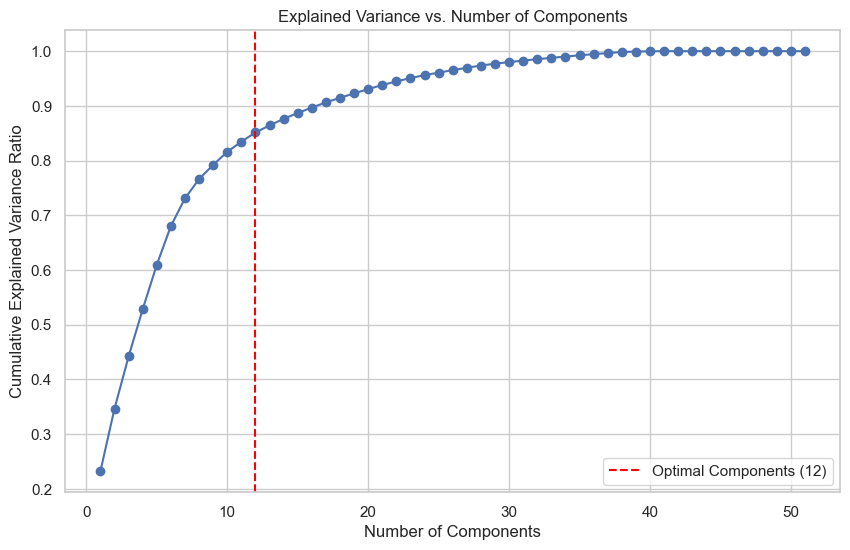

Optimal number of components: 12


In [59]:
# Initialize PCA with a large number of components
pca = PCA()

# Fit PCA on your scaled data
pca.fit(X_train_under)

# Plot the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.title("Explained Variance vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)

# Determine the optimal number of components based on the plot
# You can choose a threshold (e.g., 0.95) and find the corresponding number of components
threshold = 0.85
optimal_num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

plt.axvline(x=optimal_num_components, color='red', linestyle='--', label=f'Optimal Components ({optimal_num_components})')
plt.legend()

plt.show()

print(f"Optimal number of components: {optimal_num_components}")

In [62]:
# I deemed 12 as the ideal number of components capturing >80% of cumulative explained variance
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_train_under)

# Convert to a DataFrame from X_pca w/ original column names
pca_column_names = [f'PC{i}' for i in range(1, 13)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_column_names)

# Create a dictionary to map PCA column names to original
pca_to_original_mapping = {pca_column_names[i]: X_train_under.columns[i] for i in range(12)}  # Start from 0

# Use the mapping to match PCA component names to original columns
matching_columns = [pca_to_original_mapping[pca_col] for pca_col in X_pca_df.columns]

# Rename column names
X_pca_df.rename(columns=pca_to_original_mapping, inplace=True)

# Add 'y' column from df_factors_imputed to X_pca_df
#X_pca_df['y'] = df_factors_imputed['y']

# Display table
X_pca_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,-0.810640,0.520001,0.298560,-0.350277,1.354596,0.789097,-0.692346,0.034009,-0.623482,0.280333,-0.272174,-0.171942
1,2.730186,0.897041,-0.184418,1.504246,-0.440671,-0.210102,-0.549345,0.123442,0.126473,0.826004,0.015653,-0.150368
2,-0.814701,-1.725726,0.434242,0.360834,1.128010,-0.858437,0.042712,0.558401,-0.479450,-0.652112,1.195195,0.007851
3,2.686527,0.234773,-0.594394,0.691353,-0.890776,1.114752,-1.049731,0.588536,-0.158090,0.607936,-0.103180,-0.278431
4,3.009123,-1.058835,-0.502317,0.996355,1.241845,-0.927152,-0.838431,0.219037,0.485454,0.180673,0.066114,0.179243


In [ ]:
# Display the dimensions of the dataset
X_pca_df.shape

In [ ]:
# Display distribution of predictor variable
sns.countplot(data=X_pca_df, x='y')
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Distribution of y')
plt.show()

In [ ]:

# Isolate outcome freq. for random undersampling
positive_class = X_pca_df[X_pca_df['y'] == 1]
negative_class = X_pca_df[X_pca_df['y'] == 0]

# Randomly sample the same number of negative class as positive class
num_samples = len(positive_class)
balanced_subset = negative_class.sample(n=num_samples, random_state=1)

# Combine the balanced subsets
balanced_data = pd.concat([positive_class, balanced_subset])

# Shuffle the rows to randomize the order
balanced_data = balanced_data.sample(frac=1, random_state=1).reset_index(drop=True)

# Display distribution
sns.countplot(data=balanced_data, x='y')
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Distribution of y')
plt.show()

In [ ]:
# Split the data into train & temporary sets (70% train + 30% temp)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(balanced_data.drop(columns=['y']), balanced_data['y'], test_size=0.3, random_state=1)

# Split the temporary data into validation and test sets (50% validation + 50% test)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Display the dimensions of the subsets
print("Train set shape:", X_train_temp.shape)
print("Validation set shape:", X_validate.shape)
print("Test set shape:", X_test.shape)

## Model Development

### Neural Network

In [ ]:
# Build simple neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(12,)),  
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid') 
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_temp, y_train_temp, epochs=10, batch_size=32)

# Make predictions on the validation set
y_pred = model.predict(X_validate)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validate, y_pred_binary)
print("Validation Accuracy:", accuracy)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_validate, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# Calculate classification report
class_report = classification_report(y_validate, y_pred_binary)
print("Classification Report:\n", class_report)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_validate, y_pred)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_validate, y_pred)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Accuracy:", accuracy)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n", class_report)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Gradient Boosting

In [ ]:
# Build XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=1)

# Train the model
xgb_model.fit(X_train_temp, y_train_temp)

# Make predictions on the validation set
y_pred = xgb_model.predict(X_validate)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validate, y_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_validate, y_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_validate, y_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = xgb_model.predict_proba(X_validate)[:, 1]
roc_auc = roc_auc_score(y_validate, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_validate, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Support Vector Machine

In [ ]:
# Set parameters for SVM classifier
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=1)

# Train the model
svm_model.fit(X_train_temp, y_train_temp)

# Make predictions on the validation set
y_pred = svm_model.predict(X_validate)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validate, y_pred)
print("Validation Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_validate, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Conduct classification report
class_report = classification_report(y_validate, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC AUC
y_scores = svm_model.decision_function(X_validate)
roc_auc = roc_auc_score(y_validate, y_scores)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_validate, y_scores)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# Make predictions using the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Conduct classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC AUC
y_scores = svm_model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_scores)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Classification Tree

#### Model Fitting

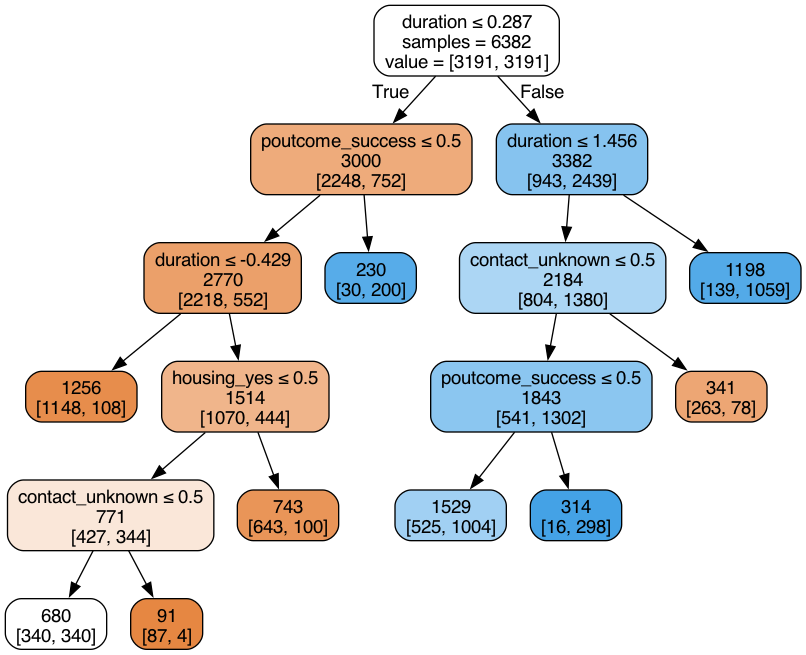

In [80]:
# fit the classification tree - balanced
classTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.005)
classTree.fit(X_train_under, y_train_under)

plotDecisionTree(classTree, feature_names=X_train_under.columns)

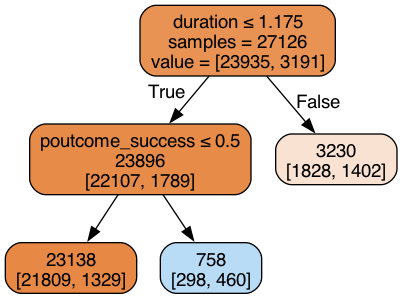

In [87]:
# fit the classification tree - imbalanced
classTree2 = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.005)
classTree2.fit(X_train_trans, y_train)

plotDecisionTree(classTree2, feature_names=X_train_trans.columns)

#### Model Predictions

In [101]:
# predicted classes - balanced
pred_t_class = classTree.predict(X_train_under)
pred_v_class = classTree.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_ct = (classTree.predict_proba(X_val_trans))
class_tree_result = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_ct],
                                  'p(1)': [p[1] for p in pred_prob_v_ct],
                                  'predicted': pred_v_class})
class_tree_result = class_tree_result.sort_values(by=['p(1)'], ascending=False)
class_tree_result.head()

,actual,p(0),p(1),predicted
6763,1,0.050955,0.949045,1
3730,1,0.050955,0.949045,1
1871,1,0.050955,0.949045,1
11128,0,0.050955,0.949045,1
13512,1,0.050955,0.949045,1


In [102]:
# predicted classes - imbalanced
pred_t_class2 = classTree2.predict(X_train_trans)
pred_v_class2 = classTree2.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_ct2 = (classTree2.predict_proba(X_val_trans))
class_tree_result2 = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_ct2],
                                  'p(1)': [p[1] for p in pred_prob_v_ct2],
                                  'predicted': pred_v_class2})
class_tree_result2 = class_tree_result2.sort_values(by=['p(1)'], ascending=False)
class_tree_result2.head()

,actual,p(0),p(1),predicted
1253,1,0.39314,0.60686,1
12320,1,0.39314,0.60686,1
3829,1,0.39314,0.60686,1
13214,0,0.39314,0.60686,1
11782,1,0.39314,0.60686,1


#### Feature Importance

In [84]:
# Get feature importances from the Classification Tree - balanced
feature_importances_class = classTree.feature_importances_
class_features_df = pd.DataFrame({'Feature': X_train_under.columns, 'Importance': feature_importances_class})
class_features_df = class_features_df.sort_values(by=['Importance'], ascending=False)
class_features_df.head()

,Feature,Importance
47,duration,0.645207
42,poutcome_success,0.176340
27,contact_unknown,0.123411
22,housing_yes,0.055042
37,month_nov,0.000000


In [89]:
# Get feature importances from the Classification Tree - imbalanced
feature_importances_class2 = classTree2.feature_importances_
class_features_df2 = pd.DataFrame({'Feature': X_train_trans.columns, 'Importance': feature_importances_class2})
class_features_df2 = class_features_df2.sort_values(by=['Importance'], ascending=False)
class_features_df2.head()

,Feature,Importance
47,duration,0.623628
42,poutcome_success,0.376372
0,job_admin.,0.000000
37,month_nov,0.000000
28,month_apr,0.000000


#### Confusion Matrices

In [93]:
# confusion matrices for classification tree - balanced
print('Training Set: Confusion matrix\n')
classificationSummary(y_train_under, pred_t_class)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_class)

cm_v_class = confusion_matrix(y_val, pred_v_class)

# Assign values to TN, TP, FN, and FP
TN = cm_v_class[0][0]
FP = cm_v_class[0][1]
FN = cm_v_class[1][0]
TP = cm_v_class[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Sensitivity (True Positive Rate): {sensitivity:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.7900)

       Prediction
Actual    0    1
     0 2481  710
     1  630 2561

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.7939)

       Prediction
Actual    0    1
     0 9637 2401
     1  395 1130
True Negatives (TN): 9637
False Positives (FP): 2401
False Negatives (FN): 395
True Positives (TP): 1130
Sensitivity (True Positive Rate): 0.74
Specificity (True Negative Rate): 0.80
Type I Error (False Positive Rate): 0.20
Type II Error (False Negative Rate): 0.26
Term subscription rate when predicted not to: 0.039


In [94]:
# confusion matrices for classification tree - imbalaced
print('Training Set: Confusion matrix\n')
classificationSummary(y_train, pred_t_class2)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_class2)

cm_v_class2 = confusion_matrix(y_val, pred_v_class2)

# Assign values to TN, TP, FN, and FP
TN2 = cm_v_class2[0][0]
FP2 = cm_v_class2[0][1]
FN2 = cm_v_class2[1][0]
TP2 = cm_v_class2[1][1]

# Calculate sensitivity and specificity
sensitivity2 = TP2 / (TP2 + FN2)
specificity2 = TN2 / (TN2 + FP2)

# Calculate Type I and Type II errors
type_I_error2 = FP2 / (FP2 + TN2)
type_II_error2 = FN2 / (FN2 + TP2)

inaccuracy_of_0_pred2 = FN2 / (TN2 + FN2)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN2}')
print(f'False Positives (FP): {FP2}')
print(f'False Negatives (FN): {FN2}')
print(f'True Positives (TP): {TP2}')
print(f'Sensitivity (True Positive Rate): {sensitivity2:.2f}')
print(f'Specificity (True Negative Rate): {specificity2:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error2:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error2:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred2:.3f}')

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.8883)

       Prediction
Actual     0     1
     0 23637   298
     1  2731   460

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.8955)

       Prediction
Actual     0     1
     0 11889   149
     1  1268   257
True Negatives (TN): 11889
False Positives (FP): 149
False Negatives (FN): 1268
True Positives (TP): 257
Sensitivity (True Positive Rate): 0.17
Specificity (True Negative Rate): 0.99
Type I Error (False Positive Rate): 0.01
Type II Error (False Negative Rate): 0.83
Term subscription rate when predicted not to: 0.096


## Logistic Regression

#### Model Fitting

In [98]:
# Create a logistic regression model - balanced
log_reg = LogisticRegression(random_state=1)

log_reg.fit(X_train_under, y_train_under)

LogisticRegression(random_state=1)

In [99]:
# Create a logistic regression model - imbalanced
log_reg2 = LogisticRegression(random_state=1)

log_reg2.fit(X_train_trans, y_train)

LogisticRegression(random_state=1)

#### Model Predictions

In [103]:
# predicted classes - balanced
pred_t_lr = log_reg.predict(X_train_under)
pred_v_lr = log_reg.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_lr = (log_reg.predict_proba(X_val_trans))
lr_result = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_lr],
                                  'p(1)': [p[1] for p in pred_prob_v_lr],
                                  'predicted': pred_v_lr})
lr_result = lr_result.sort_values(by=['p(1)'], ascending=False)
lr_result.head()

,actual,p(0),p(1),predicted
7650,1,0.000410,0.999590,1
10075,0,0.000435,0.999565,1
1149,1,0.000475,0.999525,1
13548,1,0.000763,0.999237,1
2166,0,0.000831,0.999169,1


In [104]:
# predicted classes - imbalanced
pred_t_lr2 = log_reg2.predict(X_train_trans)
pred_v_lr2 = log_reg2.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_lr2 = (log_reg2.predict_proba(X_val_trans))
lr_result2 = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_lr2],
                                  'p(1)': [p[1] for p in pred_prob_v_lr2],
                                  'predicted': pred_v_lr2})
lr_result2 = lr_result2.sort_values(by=['p(1)'], ascending=False)
lr_result2.head()

,actual,p(0),p(1),predicted
10075,0,0.007508,0.992492,1
2027,1,0.009259,0.990741,1
7650,1,0.009684,0.990316,1
1149,1,0.010956,0.989044,1
1884,1,0.013192,0.986808,1


#### Confusion Matrices

In [105]:
# confusion matrices for logistic regression - balanced
print('Training Set: Confusion matrix\n')
classificationSummary(y_train_under, pred_t_lr)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_lr)

cm_v_lr = confusion_matrix(y_val, pred_v_lr)

# Assign values to TN, TP, FN, and FP
TN = cm_v_lr[0][0]
FP = cm_v_lr[0][1]
FN = cm_v_lr[1][0]
TP = cm_v_lr[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Sensitivity (True Positive Rate): {sensitivity:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.8367)

       Prediction
Actual    0    1
     0 2621  570
     1  472 2719

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.8527)

       Prediction
Actual     0     1
     0 10414  1624
     1   374  1151
True Negatives (TN): 10414
False Positives (FP): 1624
False Negatives (FN): 374
True Positives (TP): 1151
Sensitivity (True Positive Rate): 0.75
Specificity (True Negative Rate): 0.87
Type I Error (False Positive Rate): 0.13
Type II Error (False Negative Rate): 0.25
Term subscription rate when predicted not to: 0.035


In [106]:
# confusion matrices for logistic regression - imbalaced
print('Training Set: Confusion matrix\n')
classificationSummary(y_train, pred_t_lr2)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_lr2)

cm_v_lr2 = confusion_matrix(y_val, pred_v_lr2)

# Assign values to TN, TP, FN, and FP
TN2 = cm_v_lr2[0][0]
FP2 = cm_v_lr2[0][1]
FN2 = cm_v_lr2[1][0]
TP2 = cm_v_lr2[1][1]

# Calculate sensitivity and specificity
sensitivity2 = TP2 / (TP2 + FN2)
specificity2 = TN2 / (TN2 + FP2)

# Calculate Type I and Type II errors
type_I_error2 = FP2 / (FP2 + TN2)
type_II_error2 = FN2 / (FN2 + TP2)

inaccuracy_of_0_pred2 = FN2 / (TN2 + FN2)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN2}')
print(f'False Positives (FP): {FP2}')
print(f'False Negatives (FN): {FN2}')
print(f'True Positives (TP): {TP2}')
print(f'Sensitivity (True Positive Rate): {sensitivity2:.2f}')
print(f'Specificity (True Negative Rate): {specificity2:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error2:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error2:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred2:.3f}')

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.9041)

       Prediction
Actual     0     1
     0 23320   615
     1  1986  1205

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.9034)

       Prediction
Actual     0     1
     0 11806   232
     1  1078   447
True Negatives (TN): 11806
False Positives (FP): 232
False Negatives (FN): 1078
True Positives (TP): 447
Sensitivity (True Positive Rate): 0.29
Specificity (True Negative Rate): 0.98
Type I Error (False Positive Rate): 0.02
Type II Error (False Negative Rate): 0.71
Term subscription rate when predicted not to: 0.084


## Model Analysis

For our case, the sensitivity is one of the most important metrics.